In [4]:
import os

import cv2
from PIL import Image
from ultralytics import YOLO

model = YOLO("./yolov9c.pt")

img_path = "../data/20240512/20240512_000100.jpg"

results = model.predict(img_path, conf=0.5)


image 1/1 F:\src\JPT\shibuya-scramble\notebooks\..\data\20240512\20240512_000100.jpg: 384x640 5 cars, 1 tv, 839.8ms
Speed: 1.0ms preprocess, 839.8ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


In [53]:
i = 0

for hour in range(24):
    for minute in range(60):
        img_path = f"../data/20240512/20240512_{str(hour).zfill(2)}{str(minute).zfill(2)}00.jpg"
        results = model.predict(img_path, conf=0.5)
        for item in results[0]:
            cls = int(item.boxes.cls)
            label = item.names[int(cls)]
            
            # 一般車両とタクシーを分類するため、`car`だけを対象とする
            if label != "car":
                continue
                
            x1, y1, x2, y2 = item.boxes.xyxy.cpu().numpy()[0]                
            img = Image.open(img_path)
            cropped_img = img.crop((x1, y1, x2, y2))
            try:
                cropped_img.save(f"../data/cropped/20240512/{label}/20240512_{str(hour).zfill(2)}{str(minute).zfill(2)}00_{i}.jpg")
                i += 1
            # 今回は`car`のみなので、ディレクトリが存在しなければ処理をスキップする
            except FileNotFoundError:
                pass
            
        i = 0


image 1/1 F:\src\JPT\shibuya-scramble\notebooks\..\data\20240512\20240512_000000.jpg: 384x640 2 cars, 689.7ms
Speed: 2.0ms preprocess, 689.7ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 F:\src\JPT\shibuya-scramble\notebooks\..\data\20240512\20240512_000100.jpg: 384x640 5 cars, 1 tv, 686.6ms
Speed: 1.0ms preprocess, 686.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 F:\src\JPT\shibuya-scramble\notebooks\..\data\20240512\20240512_000200.jpg: 384x640 1 person, 2 cars, 1 tv, 671.6ms
Speed: 1.0ms preprocess, 671.6ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 F:\src\JPT\shibuya-scramble\notebooks\..\data\20240512\20240512_000300.jpg: 384x640 7 cars, 1 truck, 1 traffic light, 1 tv, 688.6ms
Speed: 1.0ms preprocess, 688.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 F:\src\JPT\shibuya-scramble\notebooks\..\data\20240512\20240512_000400.jpg: 384x640 1 person, 2 car

In [10]:
img_dir = os.path.join("../data/cropped/20240512/car")
img_files = [f for f in os.listdir(img_dir) if os.path.isfile(os.path.join(img_dir, f))]

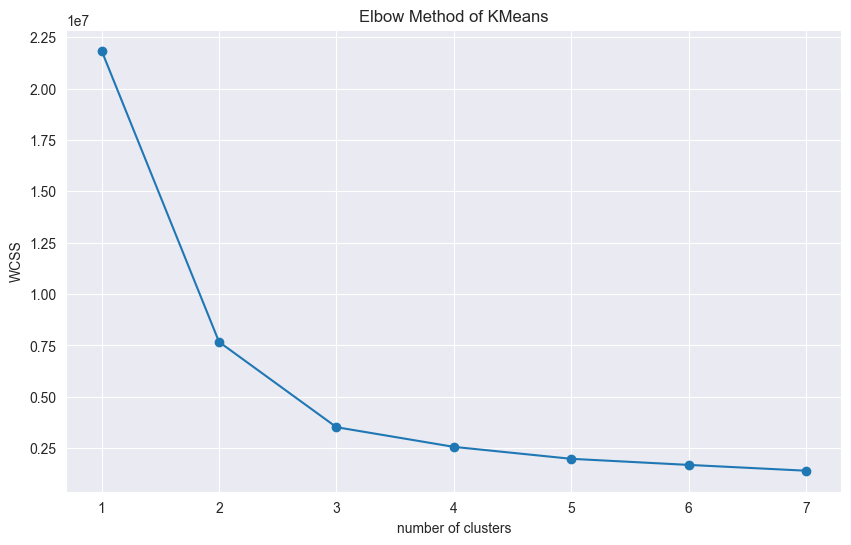

In [9]:
from PIL import Image
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


valid_img_files = [f for f in img_files if f.lower().endswith(".jpg")]
valid_sample_img_path = os.path.join(img_dir, valid_img_files[0])
valid_sample_img = Image.open(valid_sample_img_path)

valid_img_data = np.array(valid_sample_img)
pixels = valid_img_data.reshape(-1, 3)

wcss = []
cluster_range = range(1, 8)
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=1963)
    kmeans.fit(pixels)
    wcss.append(kmeans.inertia_)
    
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, wcss, marker='o')
plt.title("Elbow Method of KMeans")
plt.xlabel("number of clusters")
plt.ylabel("WCSS")
plt.grid(True)
plt.show()

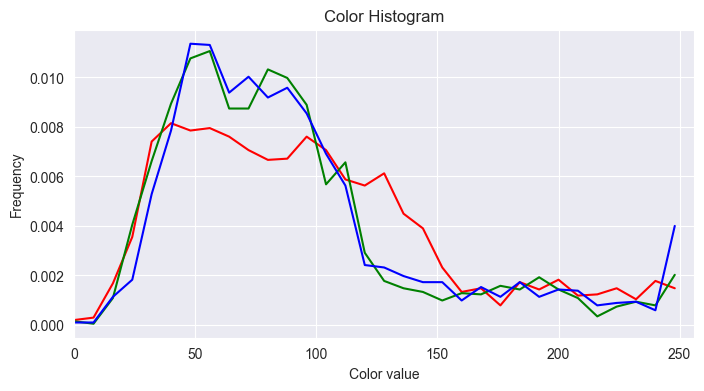

In [12]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

def calculate_histogram(image_path, bins=32, plot=False):
    # 画像を読み込み、numpy配列に変換
    image = Image.open(image_path)
    image_array = np.array(image)

    # RGBチャンネルごとのヒストグラムを計算
    red_hist, red_bin_edges = np.histogram(image_array[:, :, 0], bins=bins, range=[0, 256], density=True)
    green_hist, green_bin_edges = np.histogram(image_array[:, :, 1], bins=bins, range=[0, 256], density=True)
    blue_hist, blue_bin_edges = np.histogram(image_array[:, :, 2], bins=bins, range=[0, 256], density=True)

    # プロットする場合
    if plot:
        plt.figure(figsize=(8, 4))
        plt.title("Color Histogram")
        plt.xlabel("Color value")
        plt.ylabel("Frequency")
        plt.xlim([0, 256])  # X軸の範囲を0から256に設定
        plt.plot(red_bin_edges[0:-1], red_hist, color='red')
        plt.plot(green_bin_edges[0:-1], green_hist, color='green')
        plt.plot(blue_bin_edges[0:-1], blue_hist, color='blue')
        plt.show()

    # 各チャンネルのヒストグラムを結合して返す
    histogram = np.concatenate((red_hist, green_hist, blue_hist))
    return histogram

# 使用例
histogram = calculate_histogram(img_path, plot=True)


In [16]:
all_histograms = []
for file in valid_img_files:
    img_path = os.path.join(img_dir, file)
    hist = calculate_histogram(img_path)
    all_histograms.append(hist)
    
histogram_array = np.array(all_histograms)

kmeans = KMeans(n_clusters=3, random_state=1963)
cluster_labels = kmeans.fit_predict(histogram_array)

cluster_labels, len(cluster_labels)

(array([2, 1, 0, ..., 0, 0, 0]), 5975)

In [20]:
#coding: utf-8
import os
import shutil
import numpy as np
from PIL import Image
from skimage import io
from sklearn.cluster import KMeans


if __name__ ==  "__main__":

    # 変数名
    origin_path = '../data/cropped/20240512/car/'
    convert_path = '../data/converted/20240512/'
    group_path =  ('../data/group/20240512/')

    # 画像サイズ
    h = 100
    w = 125

    # クラスタ数
    n_cluster = 4


    # 画像サイズを揃えて保存
    for f in os.listdir(origin_path):
        print(f)
        img = Image.open(origin_path+f)
        img=img.convert('RGB')
        img_resize = img.resize((w,h))

        # もしディレクトリがなければ、そのディレクトリを作成
        if not os.path.exists(convert_path):
            os.mkdir(convert_path)

        img_resize.save(convert_path+f)

    # 3次元の画像データを2次元データに変換する
    feature = np.array([io.imread(convert_path + f)for f in os.listdir(convert_path)])
    feature = feature.reshape(len(feature), -1).astype(np.float64)

    # 学習
    model = KMeans(n_clusters=n_cluster).fit(feature)

    # ラベリングの結果
    labels = model.labels_
    print(labels)

    # 分類結果ごと、画像をディレクトリにコピー
    for label, path in zip(labels, os.listdir(convert_path)):

        if not os.path.exists(group_path):
            os.mkdir(group_path)

        copy_path = group_path+str(label)

        if not os.path.exists(copy_path):
            os.mkdir(copy_path)

        shutil.copyfile(origin_path+path, copy_path+"/"+path)
        print(label, path)


20240512_000000_0.jpg
20240512_000000_1.jpg
20240512_000100_0.jpg
20240512_000100_1.jpg
20240512_000100_2.jpg
20240512_000100_3.jpg
20240512_000100_4.jpg
20240512_000200_0.jpg
20240512_000200_1.jpg
20240512_000300_0.jpg
20240512_000300_1.jpg
20240512_000300_2.jpg
20240512_000300_3.jpg
20240512_000300_4.jpg
20240512_000300_5.jpg
20240512_000300_6.jpg
20240512_000400_0.jpg
20240512_000400_1.jpg
20240512_000500_0.jpg
20240512_000500_1.jpg
20240512_000500_2.jpg
20240512_000500_3.jpg
20240512_000500_4.jpg
20240512_000500_5.jpg
20240512_000500_6.jpg
20240512_000500_7.jpg
20240512_000500_8.jpg
20240512_000500_9.jpg
20240512_000600_0.jpg
20240512_000600_1.jpg
20240512_000600_2.jpg
20240512_000600_3.jpg
20240512_000600_4.jpg
20240512_000700_0.jpg
20240512_000700_1.jpg
20240512_000700_2.jpg
20240512_000700_3.jpg
20240512_000700_4.jpg
20240512_000700_5.jpg
20240512_000700_6.jpg
20240512_000700_7.jpg
20240512_000800_0.jpg
20240512_000800_1.jpg
20240512_000800_2.jpg
20240512_000800_3.jpg
20240512_0